FAKE JOB POSTING DETECTOR - ML TRAINING PIPELINE

[1/9] Downloading NLTK data...
✓ NLTK data downloaded

[2/9] Loading dataset...
✓ Dataset loaded successfully!
  Shape: (17880, 18)
  Columns: 18

[3/9] Performing EDA...

Dataset Info:
  Total Records: 17,880
  Features: 18

Class Distribution:
  Legitimate (0): 17,014 (95.16%)
  Fraudulent (1): 866 (4.84%)

Missing Values (%):
salary_range           83.959732
department             64.580537
required_education     45.329978
benefits               40.335570
required_experience    39.429530
function               36.101790
industry               27.421700
employment_type        19.412752
company_profile        18.501119
requirements           15.078300
dtype: float64


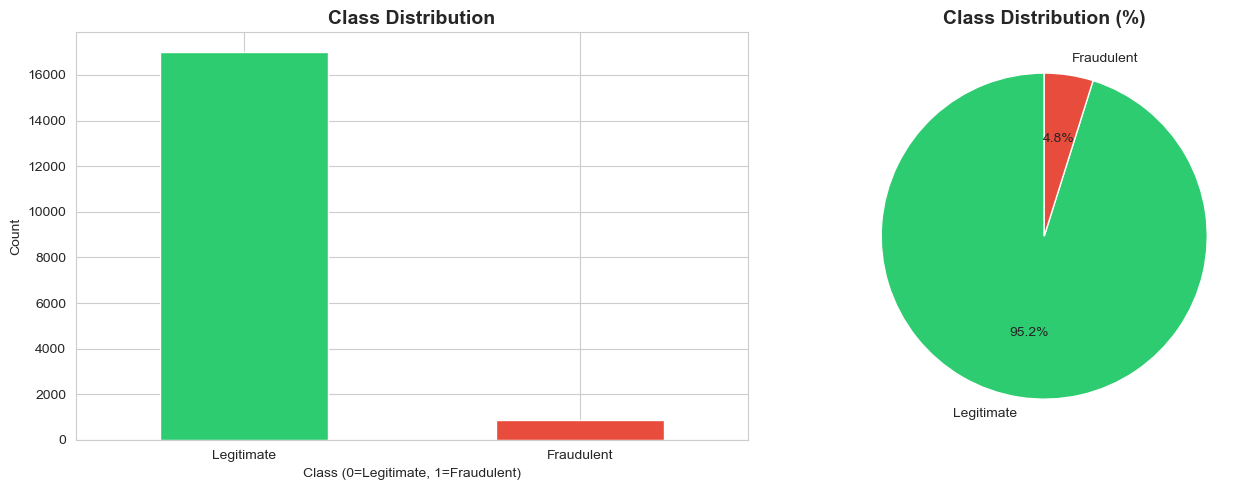


[4/9] Preprocessing text data...
  Combining text fields...
  Cleaning and preprocessing text...
  Engineering additional features...
✓ Preprocessing complete!
  Average text length (legitimate): 2007 chars
  Average text length (fraudulent): 1566 chars

[5/9] Splitting data...
✓ Data split complete!
  Training set: 14,304 samples
  Test set: 3,576 samples
  Training fraudulent: 693 (4.84%)
  Test fraudulent: 173 (4.84%)

[6/9] Creating TF-IDF features...
✓ TF-IDF vectorization complete!
  Feature matrix shape: (14304, 5000)
  Number of features: 5,000
  Sparsity: 96.77%

[7/9] Training models...

1️⃣  Logistic Regression
   Accuracy: 0.9690
   ROC-AUC: 0.9846

2️⃣  Random Forest
   Accuracy: 0.9692
   ROC-AUC: 0.9782

3️⃣  Gradient Boosting
   Accuracy: 0.9785
   ROC-AUC: 0.9272

4️⃣  Multinomial Naive Bayes
   Accuracy: 0.9754
   ROC-AUC: 0.9721


[8/9] Evaluating models...

🏆 Best Model: Logistic Regression
   ROC-AUC Score: 0.9846
   Accuracy: 0.9690

📊 Detailed Classification Rep

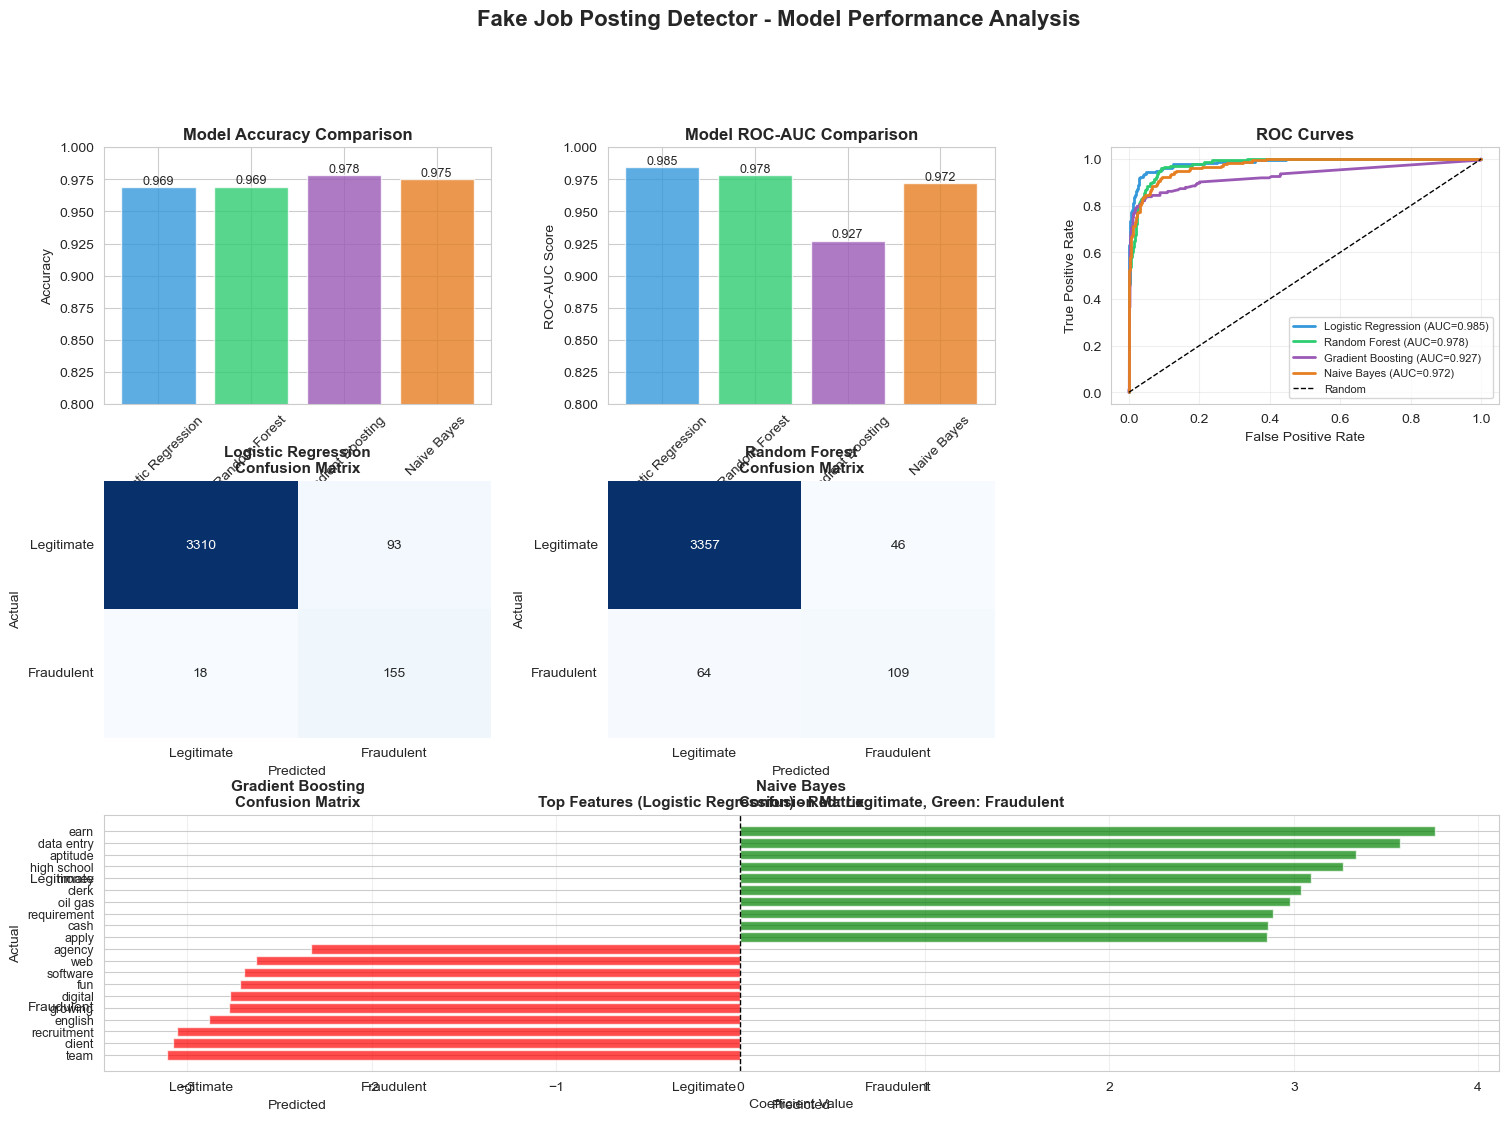


💾 Saving models...
   ✓ Saved best model: Logistic Regression
   ✓ Saved TF-IDF vectorizer
   ✓ Saved all models for comparison
   ✓ Saved model metadata

✅ TRAINING COMPLETE!

📁 Files created:
   • job_detector_model.pkl (Best model: Logistic Regression)
   • tfidf_vectorizer.pkl
   • all_models.pkl
   • model_metadata.pkl

🎯 Final Performance:
   • Best Model: Logistic Regression
   • Accuracy: 0.9690
   • ROC-AUC: 0.9846

🚀 Ready for deployment with Streamlit!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*70)
print("FAKE JOB POSTING DETECTOR - ML TRAINING PIPELINE")
print("="*70)


print("\n[1/9] Downloading NLTK data...")
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
    nltk.data.find('corpora/omw-1.4')
    print("✓ NLTK data already available")
except LookupError:
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    print("✓ NLTK data downloaded")


print("\n[2/9] Loading dataset...")

import os


if not os.path.exists('fake_job_postings.csv'):
    print("\n" + "="*70)
    print("  DATASET NOT FOUND!")
    print("="*70)
    print("\n Please download the dataset from Kaggle:")
    print("   URL: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction")
    print("\n Steps:")
    print("   1. Visit the URL above")
    print("   2. Click 'Download' button")
    print("   3. Extract 'fake_job_postings.csv'")
    print("   4. Place it in the same directory as this notebook")
    print("\n OR use Kaggle API:")
    print("   kaggle datasets download -d shivamb/real-or-fake-fake-jobposting-prediction")
    print("   unzip real-or-fake-fake-jobposting-prediction.zip")
    print("="*70)
    
    
    raise FileNotFoundError("Dataset not found. Please download it following the instructions above.")


df = pd.read_csv('fake_job_postings.csv')
print(f" Dataset loaded successfully!")
print(f"  Shape: {df.shape}")
print(f"  Columns: {len(df.columns)}")


print("\n[3/9] Performing EDA...")

print("\nDataset Info:")
print(f"  Total Records: {len(df):,}")
print(f"  Features: {df.shape[1]}")

print("\nClass Distribution:")
class_dist = df['fraudulent'].value_counts()
print(f"  Legitimate (0): {class_dist[0]:,} ({class_dist[0]/len(df)*100:.2f}%)")
print(f"  Fraudulent (1): {class_dist[1]:,} ({class_dist[1]/len(df)*100:.2f}%)")

print("\nMissing Values (%):")
missing = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print(missing[missing > 0].head(10))


fig, axes = plt.subplots(1, 2, figsize=(14, 5))


class_dist.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=Legitimate, 1=Fraudulent)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Legitimate', 'Fraudulent'], rotation=0)


colors = ['#2ecc71', '#e74c3c']
axes[1].pie(class_dist.values, labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


print("\n[4/9] Preprocessing text data...")

def preprocess_text(text):
    """Clean and preprocess text data"""
    if pd.isna(text):
        return ""
    
   
    text = str(text).lower()
    
   
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
   
    text = re.sub(r'\S+@\S+', '', text)
    
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    
    text = ' '.join(text.split())
    

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    
    return ' '.join(words)


print("  Combining text fields...")
df['combined_text'] = (
    df['title'].fillna('') + ' ' + 
    df['company_profile'].fillna('') + ' ' + 
    df['description'].fillna('') + ' ' + 
    df['requirements'].fillna('') + ' ' +
    df['benefits'].fillna('')
)

print("  Cleaning and preprocessing text...")
df['cleaned_text'] = df['combined_text'].apply(preprocess_text)


print("  Engineering additional features...")
df['text_length'] = df['cleaned_text'].apply(len)
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df['has_company_profile'] = df['company_profile'].notna().astype(int)
df['has_requirements'] = df['requirements'].notna().astype(int)
df['has_benefits'] = df['benefits'].notna().astype(int)
df['has_questions'] = df['has_questions'].fillna(0).astype(int)
df['has_company_logo'] = df['has_company_logo'].fillna(0).astype(int)
df['telecommuting'] = df['telecommuting'].fillna(0).astype(int)

print(f"✓ Preprocessing complete!")
print(f"  Average text length (legitimate): {df[df['fraudulent']==0]['text_length'].mean():.0f} chars")
print(f"  Average text length (fraudulent): {df[df['fraudulent']==1]['text_length'].mean():.0f} chars")


print("\n[5/9] Splitting data...")

X = df['cleaned_text']
y = df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Data split complete!")
print(f"  Training set: {len(X_train):,} samples")
print(f"  Test set: {len(X_test):,} samples")
print(f"  Training fraudulent: {y_train.sum():,} ({y_train.sum()/len(y_train)*100:.2f}%)")
print(f"  Test fraudulent: {y_test.sum():,} ({y_test.sum()/len(y_test)*100:.2f}%)")


print("\n[6/9] Creating TF-IDF features...")

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✓ TF-IDF vectorization complete!")
print(f"  Feature matrix shape: {X_train_tfidf.shape}")
print(f"  Number of features: {X_train_tfidf.shape[1]:,}")
print(f"  Sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))*100:.2f}%")


print("\n[7/9] Training models...")
print("="*70)

models = {}
results = {}


print("\n  Logistic Regression")
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced', C=1.0)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)
lr_proba = lr_model.predict_proba(X_test_tfidf)[:, 1]

models['Logistic Regression'] = lr_model
results['Logistic Regression'] = {
    'predictions': lr_pred,
    'probabilities': lr_proba,
    'accuracy': accuracy_score(y_test, lr_pred),
    'roc_auc': roc_auc_score(y_test, lr_proba)
}

print(f"   Accuracy: {results['Logistic Regression']['accuracy']:.4f}")
print(f"   ROC-AUC: {results['Logistic Regression']['roc_auc']:.4f}")

# Model 2: Random Forest
print("\n Random Forest")
rf_model = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    class_weight='balanced',
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1
)
rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_test_tfidf)
rf_proba = rf_model.predict_proba(X_test_tfidf)[:, 1]

models['Random Forest'] = rf_model
results['Random Forest'] = {
    'predictions': rf_pred,
    'probabilities': rf_proba,
    'accuracy': accuracy_score(y_test, rf_pred),
    'roc_auc': roc_auc_score(y_test, rf_proba)
}

print(f"   Accuracy: {results['Random Forest']['accuracy']:.4f}")
print(f"   ROC-AUC: {results['Random Forest']['roc_auc']:.4f}")

# Model 3: Gradient Boosting
print("\n Gradient Boosting")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_tfidf, y_train)
gb_pred = gb_model.predict(X_test_tfidf)
gb_proba = gb_model.predict_proba(X_test_tfidf)[:, 1]

models['Gradient Boosting'] = gb_model
results['Gradient Boosting'] = {
    'predictions': gb_pred,
    'probabilities': gb_proba,
    'accuracy': accuracy_score(y_test, gb_pred),
    'roc_auc': roc_auc_score(y_test, gb_proba)
}

print(f"   Accuracy: {results['Gradient Boosting']['accuracy']:.4f}")
print(f"   ROC-AUC: {results['Gradient Boosting']['roc_auc']:.4f}")

# Model 4: Naive Bayes
print("\n Multinomial Naive Bayes")
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_test_tfidf)
nb_proba = nb_model.predict_proba(X_test_tfidf)[:, 1]

models['Naive Bayes'] = nb_model
results['Naive Bayes'] = {
    'predictions': nb_pred,
    'probabilities': nb_proba,
    'accuracy': accuracy_score(y_test, nb_pred),
    'roc_auc': roc_auc_score(y_test, nb_proba)
}

print(f"   Accuracy: {results['Naive Bayes']['accuracy']:.4f}")
print(f"   ROC-AUC: {results['Naive Bayes']['roc_auc']:.4f}")

print("\n" + "="*70)


print("\n[8/9] Evaluating models...")

best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = models[best_model_name]

print(f"\n Best Model: {best_model_name}")
print(f"   ROC-AUC Score: {results[best_model_name]['roc_auc']:.4f}")
print(f"   Accuracy: {results[best_model_name]['accuracy']:.4f}")


print(f"\n📊 Detailed Classification Report ({best_model_name}):")
print(classification_report(y_test, results[best_model_name]['predictions'], 
                          target_names=['Legitimate', 'Fraudulent']))


print("\n[9/9] Creating visualizations...")

# Create comprehensive visualizations
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Model Comparison - Accuracy
ax1 = fig.add_subplot(gs[0, 0])
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
colors_bar = ['#3498db', '#2ecc71', '#9b59b6', '#e67e22']
bars = ax1.bar(model_names, accuracies, color=colors_bar, alpha=0.8)
ax1.set_title('Model Accuracy Comparison', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.8, 1.0])
ax1.tick_params(axis='x', rotation=45)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Model Comparison - ROC-AUC
ax2 = fig.add_subplot(gs[0, 1])
roc_aucs = [results[m]['roc_auc'] for m in model_names]
bars = ax2.bar(model_names, roc_aucs, color=colors_bar, alpha=0.8)
ax2.set_title('Model ROC-AUC Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('ROC-AUC Score')
ax2.set_ylim([0.8, 1.0])
ax2.tick_params(axis='x', rotation=45)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 3. ROC Curves
ax3 = fig.add_subplot(gs[0, 2])
for model_name, color in zip(model_names, colors_bar):
    fpr, tpr, _ = roc_curve(y_test, results[model_name]['probabilities'])
    ax3.plot(fpr, tpr, label=f"{model_name} (AUC={results[model_name]['roc_auc']:.3f})", 
            color=color, linewidth=2)
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right', fontsize=8)
ax3.grid(True, alpha=0.3)

# 4-7. Confusion Matrices for all models
for idx, model_name in enumerate(model_names):
    ax = fig.add_subplot(gs[1 + idx//2, idx%2])
    cm = confusion_matrix(y_test, results[model_name]['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{model_name}\nConfusion Matrix', fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(['Legitimate', 'Fraudulent'], rotation=0)
    ax.set_yticklabels(['Legitimate', 'Fraudulent'], rotation=0)

# 8. Feature Importance (for best model if it's tree-based)
ax8 = fig.add_subplot(gs[2, :])
if hasattr(best_model, 'feature_importances_'):
    feature_names = tfidf.get_feature_names_out()
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-20:]
    
    ax8.barh(range(len(indices)), importances[indices], color='#3498db', alpha=0.8)
    ax8.set_yticks(range(len(indices)))
    ax8.set_yticklabels([feature_names[i] for i in indices], fontsize=9)
    ax8.set_xlabel('Feature Importance')
    ax8.set_title(f'Top 20 Important Features ({best_model_name})', fontsize=12, fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='x')
elif hasattr(best_model, 'coef_'):
    feature_names = tfidf.get_feature_names_out()
    coef = best_model.coef_[0]
    top_positive = np.argsort(coef)[-10:]
    top_negative = np.argsort(coef)[:10]
    top_indices = np.concatenate([top_negative, top_positive])
    
    colors_feat = ['red' if coef[i] < 0 else 'green' for i in top_indices]
    ax8.barh(range(len(top_indices)), coef[top_indices], color=colors_feat, alpha=0.7)
    ax8.set_yticks(range(len(top_indices)))
    ax8.set_yticklabels([feature_names[i] for i in top_indices], fontsize=9)
    ax8.set_xlabel('Coefficient Value')
    ax8.set_title(f'Top Features ({best_model_name}) - Red: Legitimate, Green: Fraudulent', 
                 fontsize=11, fontweight='bold')
    ax8.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax8.grid(True, alpha=0.3, axis='x')

plt.suptitle('Fake Job Posting Detector - Model Performance Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

# ========================
# 9. SAVE MODELS
# ========================
print("\n💾 Saving models...")

# Save the best model
with open('job_detector_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"   ✓ Saved best model: {best_model_name}")

# Save vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("   ✓ Saved TF-IDF vectorizer")

# Save all models for comparison
with open('all_models.pkl', 'wb') as f:
    pickle.dump(models, f)
print("   ✓ Saved all models for comparison")

# Save model metadata
metadata = {
    'best_model': best_model_name,
    'accuracy': results[best_model_name]['accuracy'],
    'roc_auc': results[best_model_name]['roc_auc'],
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'features': X_train_tfidf.shape[1],
    'model_results': {name: {'accuracy': res['accuracy'], 'roc_auc': res['roc_auc']} 
                     for name, res in results.items()}
}

with open('model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("   ✓ Saved model metadata")

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)
print(f"\n📁 Files created:")
print(f"   • job_detector_model.pkl (Best model: {best_model_name})")
print(f"   • tfidf_vectorizer.pkl")
print(f"   • all_models.pkl")
print(f"   • model_metadata.pkl")
print(f"\n🎯 Final Performance:")
print(f"   • Best Model: {best_model_name}")
print(f"   • Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   • ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"\n🚀 Ready for deployment with Streamlit!")
print("="*70)